In [33]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt 
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
%matplotlib inline

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


## Data preparation

In [3]:
os.chdir('data/dogs-vs-cats')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')
    
    for c in random.sample(glob.glob('cat*'), 500):
        shutil.move(c, 'train/cat')
    for c in random.sample(glob.glob('dog*'), 500):
        shutil.move(c, 'train/dog')
    for c in random.sample(glob.glob('cat*'), 100):
        shutil.move(c, 'valid/cat')
    for c in random.sample(glob.glob('dog*'), 100):
        shutil.move(c, 'valid/dog')
    for c in random.sample(glob.glob('cat*'), 50):
        shutil.move(c, 'test/cat')
    for c in random.sample(glob.glob('dog*'), 50):
        shutil.move(c, 'test/dog')
        
os.chdir('../../')

In [36]:
train_path = 'data/dogs-vs-cats/train'
valid_path = 'data/dogs-vs-cats/valid'
test_path = 'data/dogs-vs-cats/test'

In [37]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
               .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat','dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
               .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat','dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
               .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat','dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [6]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [7]:
imgs, labels = next(train_batches)

In [8]:
# Plot the images from train_batches
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        plt.tight_layout()
        plt.show()

In [9]:
#plotImages(imgs)
print(labels[0])

[1. 0.]


In [10]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [11]:
for layer in model.layers:
    print(layer.output_shape)

(None, 224, 224, 32)
(None, 112, 112, 32)
(None, 112, 112, 64)
(None, 56, 56, 64)
(None, 200704)
(None, 2)


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In [13]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
100/100 - 3s - loss: 15.7531 - accuracy: 0.5390 - val_loss: 6.5208 - val_accuracy: 0.5600
Epoch 2/10
100/100 - 2s - loss: 2.6860 - accuracy: 0.7540 - val_loss: 3.7274 - val_accuracy: 0.6300
Epoch 3/10
100/100 - 2s - loss: 0.7607 - accuracy: 0.8750 - val_loss: 3.5571 - val_accuracy: 0.5950
Epoch 4/10
100/100 - 2s - loss: 0.1459 - accuracy: 0.9640 - val_loss: 2.8208 - val_accuracy: 0.6200
Epoch 5/10
100/100 - 2s - loss: 0.0367 - accuracy: 0.9870 - val_loss: 2.6461 - val_accuracy: 0.6200
Epoch 6/10
100/100 - 2s - loss: 0.0166 - accuracy: 0.9940 - val_loss: 2.6667 - val_accuracy: 0.6450
Epoch 7/10
100/100 - 2s - loss: 0.0176 - accuracy: 0.9920 - val_loss: 3.4162 - val_accuracy: 0.6000
Epoch 8/10
100/100 - 2s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 2.6634 - val_accuracy: 0.6150
Epoch 9/10
100/100 - 2s - loss: 6.5024e-04 - accuracy: 1.0000 - val_loss: 2.5781 - val_accuracy: 0.6200
Epoch 10/10
100/100 - 2s - loss: 2.3596e-04 - accuracy: 1.0000 - val_loss: 2.5774 - val_accurac

## Predict

In [46]:
test_imgs, test_labels = next (test_batches)
#plotImages(test_imgs)
print(test_labels)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [47]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [50]:
predictions = model.predict(x=test_batches, verbose=0)
print(predictions[:10])

[[6.1734245e-06 9.9999380e-01]
 [9.9922669e-01 7.7334262e-04]
 [2.6330792e-07 9.9999976e-01]
 [9.9810755e-01 1.8923770e-03]
 [5.1232867e-16 1.0000000e+00]
 [3.9941770e-01 6.0058230e-01]
 [9.9995458e-01 4.5357665e-05]
 [9.3518215e-01 6.4817876e-02]
 [9.8236865e-01 1.7631311e-02]
 [9.9399370e-01 6.0063140e-03]]


In [56]:
print(np.round(predictions[:20]))

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [42]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [43]:
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.xticks(tick_marks, classes)
    
    if normalize:
        cm=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j], horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [44]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[29 21]
 [12 38]]


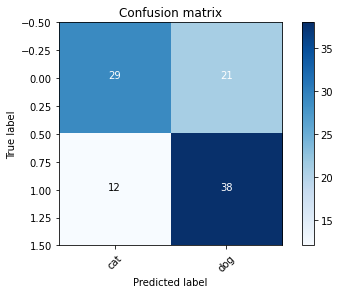

In [45]:
cm_plot_labels=['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion matrix")

In [34]:
model = load_model('models/jupyter-CNN_model.h5')

In [28]:
if os.path.isfile('models/jupyter-CNN_model.h5') is False:
    model.save('models/jupyter-CNN_model.h5')

# Build Fine-tuned VGG16 model

In [3]:
# Download model - requries network connection
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [6]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [19]:
for layer in vgg16_model.layers:
    try:
        print(layer.activation)
    except:
        print('exception')

exception
<function relu at 0x7f223b1149d0>
<function relu at 0x7f223b1149d0>
exception
<function relu at 0x7f223b1149d0>
<function relu at 0x7f223b1149d0>
exception
<function relu at 0x7f223b1149d0>
<function relu at 0x7f223b1149d0>
<function relu at 0x7f223b1149d0>
exception
<function relu at 0x7f223b1149d0>
<function relu at 0x7f223b1149d0>
<function relu at 0x7f223b1149d0>
exception
<function relu at 0x7f223b1149d0>
<function relu at 0x7f223b1149d0>
<function relu at 0x7f223b1149d0>
exception
exception
<function relu at 0x7f223b1149d0>
<function relu at 0x7f223b1149d0>
<function softmax at 0x7f223b114310>


In [21]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [29]:
for layer in model.layers:
    layer.trainable = False

In [30]:
model.add(Dense(units=2, activation='softmax'))

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      